# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [3]:
from sklearn.exceptions import NotFittedError

In [4]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.epochs, self.losses = [], []
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        return 1 / (1 + np.exp(-1 * X @ weights))
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        loss = sum(np.log(1 + np.exp(-1 * (x @ weights) * y))) / X.shape[0] # благодаря numpy вместо цикла делаю все матричными операциями
        l2_norm_squared = sum(weights**2)
        penalty = l2_norm_squared / (2*self.C)
        return loss + penalty
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        
        for i in range(self.max_iter):
            self.epochs.append(i)
            self.losses.append(self.get_loss(X_ext, self.weights_, y))
            
            N = X_ext.shape[0]
            s = 0
            for j in range(N):
                brackets_ = 1 - 1/(1 + np.exp(-X_ext[j] @ self.weights_ * y[j])) # число
                mult = y[j] * X_ext[j] * brackets_ # число * вектор * число = вектор по кол-ву фичей
                s += mult # вектор

            delta = -(s / N - self.weights_ / self.C)
            self.weights_ -= self.eta * delta
            if sum(delta**2)**0.5 < self.tol:
                break
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        return np.where(self.predict_proba(X) >= 0.5, 1, -1)

In [5]:
from sklearn import datasets
from sklearn import metrics

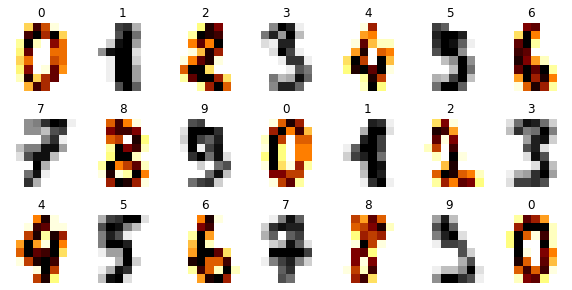

In [6]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [7]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [8]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [9]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [10]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [11]:
lr_clf.fit(X_train, y_train)

In [12]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [13]:
model = CustomLogisticRegression()

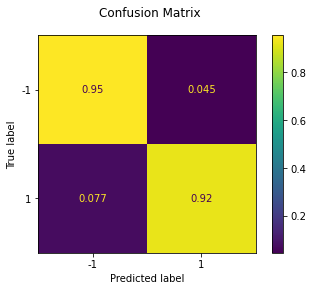

In [14]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [15]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [16]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Loss')

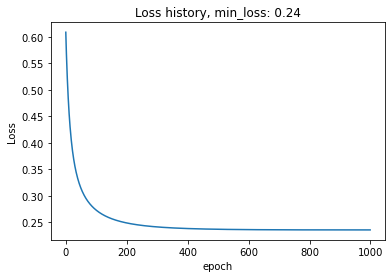

In [18]:
sns.lineplot(model.epochs, model.losses)
plt.title(f'Loss history, min_loss: {round(min(model.losses), 2)}')
plt.xlabel('epoch')
plt.ylabel('Loss')

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

In [32]:
def examine_eta(eta, X_train, y_train):
    model = CustomLogisticRegression(eta=eta)
    model.fit(X_train, y_train)
    plt.figure(figsize=(6, 3))
    plt.plot(model.epochs, model.losses)
    plt.title(f"eta: {eta}, min loss: {round(min(model.losses), 2)}")
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.show

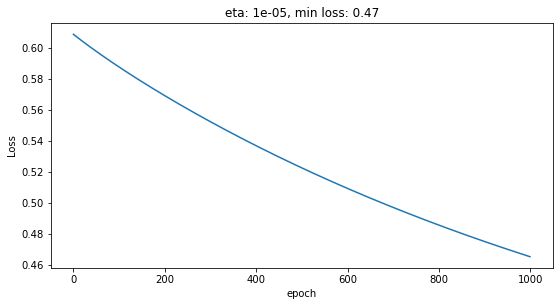

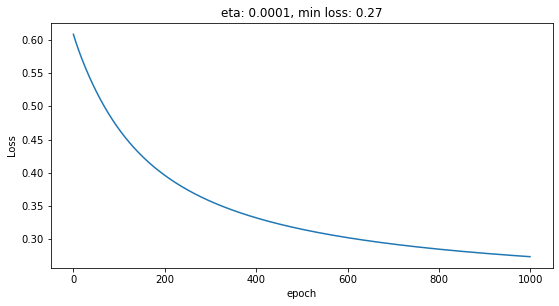

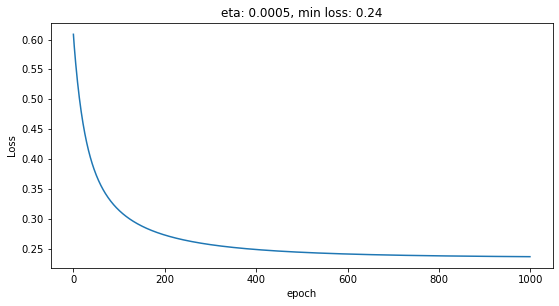

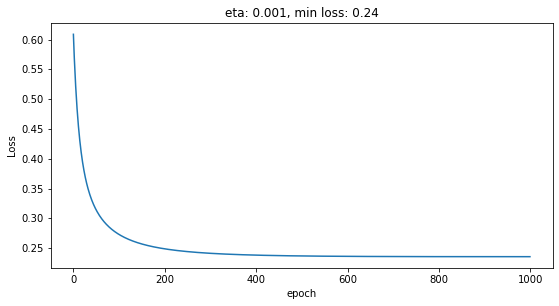

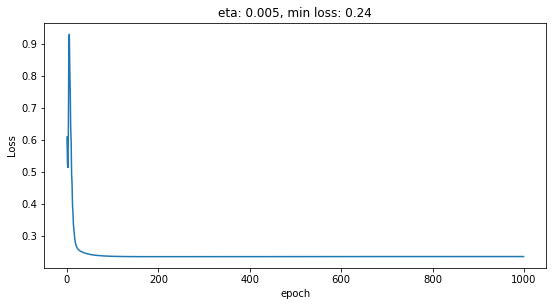

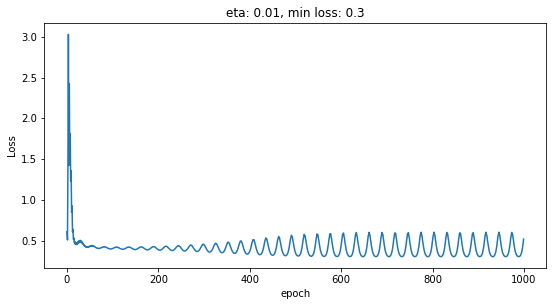

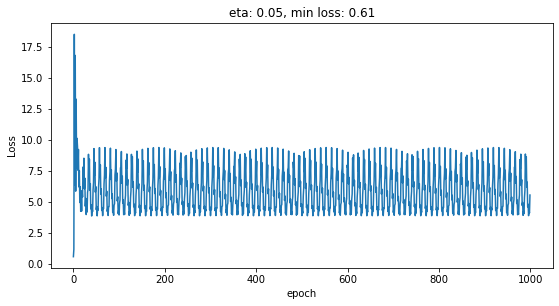

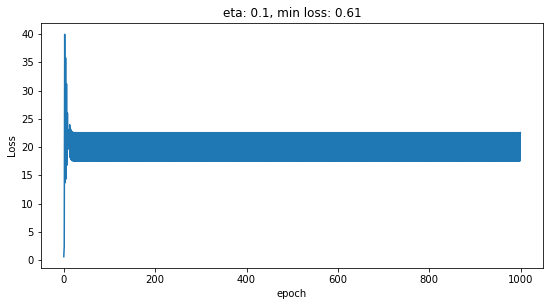

In [35]:
etas = [0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
for eta in etas:
    examine_eta(eta, X_train, y_train)

Если поставить слишком маленькое значение, то до 1000 итерации модель не успевает найти оптимальную точку. Если же, наоборот, поставить слишком высокое значение, то модель начинает ее "перескакивать" и в итоге не может попасть в оптимум. eta = 0.001 - оптимальное значение для текущей задачи

**(0.5 points)** Try different regularization parameter values and compare the model quality.

In [55]:
def examine_reg_param(C, X_train, y_train):
    model = CustomLogisticRegression(C=C)
    model.fit(X_train, y_train)
    
    min_loss = round(min(model.losses), 2)
    test_acc = metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test)
    plt.plot(model.epochs, model.losses, label=f'C: {C}, min loss: {min_loss}, test_acc: {test_acc}')

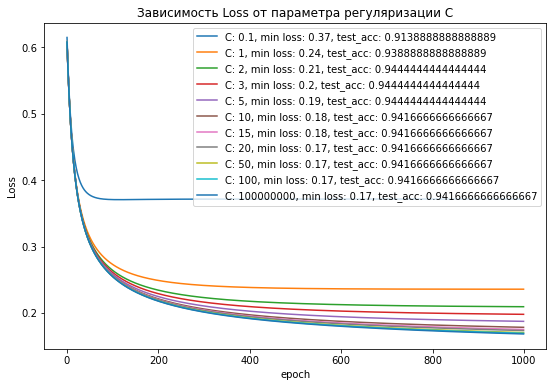

In [56]:
C = [0.1, 1, 2, 3, 5, 10, 15, 20, 50, 100, 100000000]

plt.figure(figsize=(9, 6))
plt.title("Изменение сходимости Loss в зависимости от параметра регуляризации C")
plt.xlabel('epoch')
plt.ylabel('Loss')
for c in C:
    examine_reg_param(c, X_train, y_train)
plt.legend()

Уменьшение параметра решуляризации увеличивает штраф за размеры коэффициентов, в то время как увеличение весов уменьшает этот штраф. Наименьшая ошибка составила 0,17 (при 0,24 при стандартном параметре 1), после 20 она перестала значимо уменьшаться. Максимальный Accuracy 0,944. Оптимальным параметром можно выбрать C=5, при нем минимальная ошибка и максимальный Accuracy

**(0.5 points)** Compare zero initialization and random initialization. 

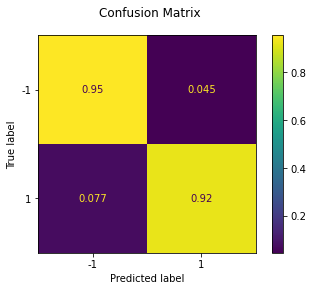

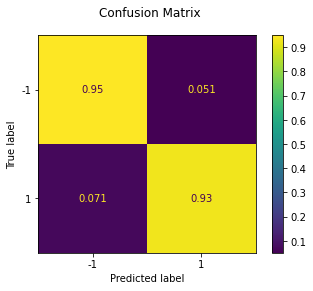

Random Accuracy. train: 0.9109255393180237, test: 0.9388888888888889
Zero Accuracy. train: 0.9116214335421016, test: 0.9388888888888889


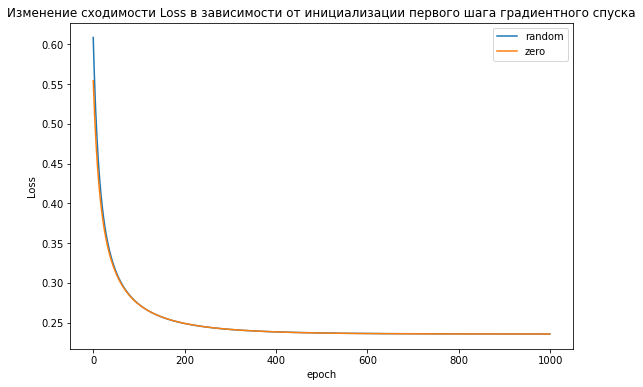

In [59]:
model_rand = CustomLogisticRegression(zero_init=False)
model_zero = CustomLogisticRegression(zero_init=True)

train_acc_rand, test_acc_rand = fit_evaluate(model_rand, X_train, y_train, X_test, y_test)
train_acc_zero, test_acc_zero = fit_evaluate(model_zero, X_train, y_train, X_test, y_test)
print(f'Random Accuracy. train: {train_acc_rand}, test: {test_acc_rand}')
print(f'Zero Accuracy. train: {train_acc_zero}, test: {test_acc_zero}')


plt.figure(figsize=(9, 6))
plt.title("Изменение сходимости Loss в зависимости от инициализации первого шага градиентного спуска")
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.plot(model_rand.epochs, model_rand.losses, label='random')
plt.plot(model_zero.epochs, model_zero.losses, label='zero')
plt.legend()

Для получившейся модели не особо сыграло роль, из какой точки начинать оптимизацию, это повлияло только на начальный уровень ошибки. Accuracy на тестовых данных получились одинаковыми при обоих типах инициализации

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [67]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        self.classes_ = []
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        # <your code>
        P = np.zeros(shape=(len(X), len(Y)))

        for i in range(len(X)):
            for j in range(len(Y)):
                P[i][j] = np.linalg.norm(X[i] - Y[j], 2)
        return P
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        # <your code>
        class_weights = {cl: 0 for cl in self.classes_}
        for cl, w in zip(y, weights):
            class_weights[cl] += w
        return np.array([class_weights[cl] for cl in self.classes_])
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 1 / (P + self.eps)
                
            # <your code>
            k = self.n_neighbors
            prob = []
            for i in range(P.shape[0]):
                neighbours_idxs = np.sort(np.argpartition(P[i], k)[:k])
                
                w_cl = weights_of_points[i][neighbours_idxs] # вектор отфильтрованных весов
                y_cl = self.y[neighbours_idxs] # вектор отфильтрованных классов
                weights_i = self.get_class_weights(y_cl, w_cl)
                prob_i =  weights_i / sum(weights_i)
                prob.append(prob_i) 
            return np.array(prob)
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        return self.classes_[np.argmax(self.predict_proba(X), axis=1)]

In [68]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [69]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [70]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

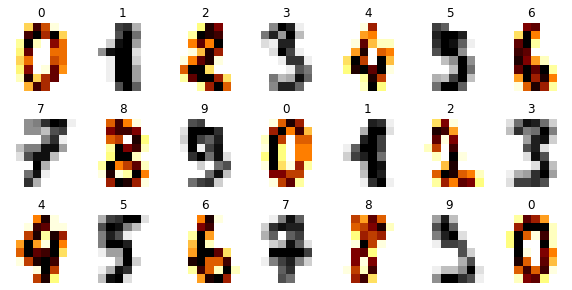

In [71]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [72]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [73]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

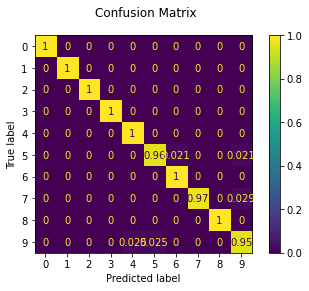

In [74]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [75]:
print(train_acc, test_acc)

1.0 0.9861111111111112


In [76]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

Модель иногда принимает 5 за 6 или 9, 7 за 9, 9 за 4 или 5. 5 и 9 иногда путаются, так как "хвостик" у 5 может быть чуть ниже опущен чем обычно и модель считает, что он почти замыкается. Аналогично и с путаницей между 5 и 6. 7 принимается за 9, так как средняя палочка тоже иногда почти соединяется с верхней и почти образует "колечко". 9 может приниматьзся за 4 когда нижний хвостик загибается влево несильно 

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

In [77]:
def examine_param(n, weights, X_train, y_train):
    model = CustomKNeighborsClassifier(n_neighbors=n, weights=weights)
    train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
    print(f'n: {n}, weights: {weights}, train_acc: {train_acc}, test_acc: {test_acc}')
    return (train_acc, test_acc)

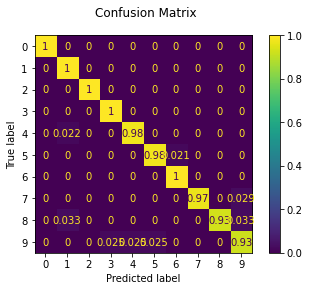

n: 1, weights: distance, train_acc: 1.0, test_acc: 0.9777777777777777


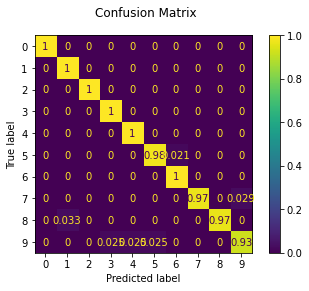

n: 3, weights: distance, train_acc: 1.0, test_acc: 0.9833333333333333


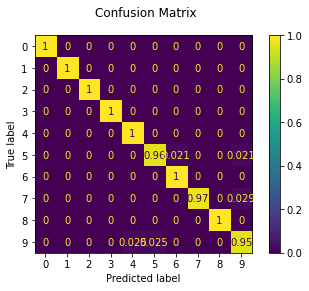

n: 5, weights: distance, train_acc: 1.0, test_acc: 0.9861111111111112


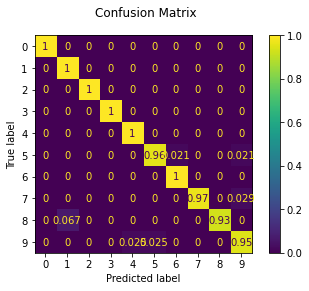

n: 10, weights: distance, train_acc: 1.0, test_acc: 0.9805555555555555


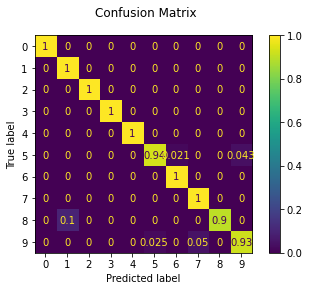

n: 30, weights: distance, train_acc: 1.0, test_acc: 0.975


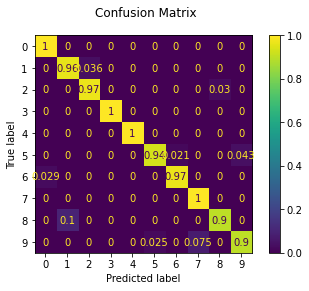

n: 50, weights: distance, train_acc: 1.0, test_acc: 0.9638888888888889


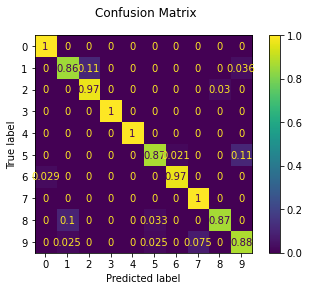

n: 100, weights: distance, train_acc: 1.0, test_acc: 0.9416666666666667


In [83]:
N = [1, 3, 5, 10, 30, 50, 100]
Accuracy_train = []
Accuracy_test = []

for k in N:
    train_acc, test_acc = examine_param(k, 'distance', X_train, y_train)
    Accuracy_train.append(train_acc)
    Accuracy_test.append(test_acc)


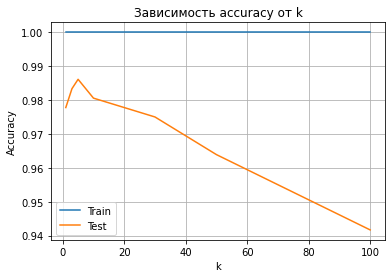

In [86]:
plt.plot(N, Accuracy_train, label='Train')
plt.plot(N, Accuracy_test, color='C1', label='Test')
plt.title('Зависимость accuracy от k')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()             
plt.show()

In [89]:
print(f'Max accuracy: {max(Accuracy_test)}, k = {N[np.argmax(Accuracy_test)]}')

Max accuracy: 0.9861111111111112, k = 5


Наилучшее качество достигается при k=5. Помимо самого высокого accuracy, при k=5 в confusion matrix наблюдается наименьшее количество ошибок

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

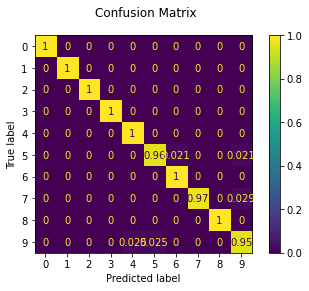

n: 5, weights: distance, train_acc: 1.0, test_acc: 0.9861111111111112


In [93]:
examine_param(5, 'distance', X_train, y_train);

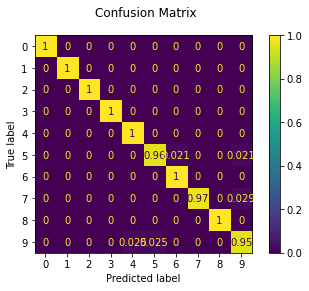

n: 5, weights: uniform, train_acc: 0.9895615866388309, test_acc: 0.9861111111111112


In [96]:
examine_param(5, 'uniform', X_train, y_train);

При n=5 различий почти нет. Только в accuracy на тренировочных данных. Попробуем увеличить n

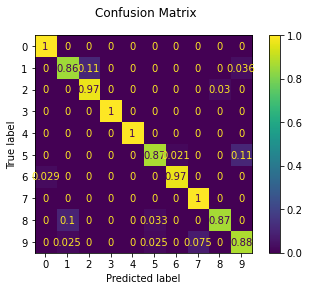

n: 100, weights: distance, train_acc: 1.0, test_acc: 0.9416666666666667


In [100]:
examine_param(100, 'distance', X_train, y_train);

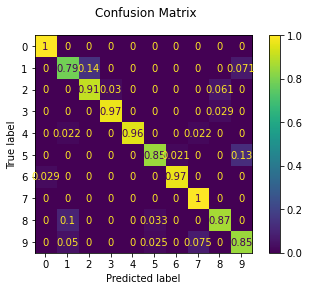

n: 100, weights: uniform, train_acc: 0.9220598469032707, test_acc: 0.9166666666666666


In [101]:
examine_param(100, 'uniform', X_train, y_train);

При сильном увеличении n начали наблюдаться расхождения в качестве моделей. При этом модель, в которой все соседи равнозначны, чаще ошибается, и у нее меньше accuracy. Думаю, это связано с тем, что при большом количестве соседей ярче проявляется эффект от придания весов в зависимости от удаленности. Благодаря этому модель работает точнее, так как более близким соседям придает более высокий вес, а далеким соседям меньший. В uniform модели далекиие соседи влияют на определение класса наравне с близкими, что ведет к большему количеству ошибок. 

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

В данной задаче можно попробовать рассчитать вместо евклидовой манхэттенскую норму (L1). Так как все фичи у нас в одной размерности и по сути знчат одно и то же, но на разных пикселях, то возводя в квадрат разницу между координатами мы искусственно "уделяем" далекие друг от друга объекты и "приближаем" близкие. Применение манхэттенской нормы позволило бы избежать этого эффекта

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

Например, задача поиска схожих текстов. Для такой задачи хорошо подойдет использование косинусного расстояние, которое позволяет сказать, насколько два текста похожи между собой, где важно не абсолютное расстояние между векторами а их направление друг относительно друга

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [ ]:
PATH = "./data/"

In [ ]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [ ]:
data.head()

### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [ ]:
## your code

< your thoughts >

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

In [ ]:
## your code

< your thoughts >

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

In [ ]:
## your code

< your thoughts >

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [ ]:
## your code

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

< your thoughts >

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [ ]:
## your code

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [ ]:
## your code

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.